In [1]:
import numpy as np
import pandas as pd


In [2]:
data_dir = './data/'
df_household = pd.read_csv(data_dir + 'ss16hwa.csv')
df_household = df_household[(df_household["PUMA"] == 11601) | (df_household["PUMA"] == 11602) | 
                     (df_household["PUMA"] == 11603) | (df_household["PUMA"] == 11604) |
                     (df_household["PUMA"] == 11605)]

df_person = pd.read_csv(data_dir + 'ss16pwa.csv')
df_person = df_person[(df_person["PUMA"] == 11601) | (df_person["PUMA"] == 11602) | 
                     (df_person["PUMA"] == 11603) | (df_person["PUMA"] == 11604) |
                     (df_person["PUMA"] == 11605)]

#print (df_person)
#print (df_person['RAC1P'].median())

In [3]:
# LOAD AMI DATA
df_AMI = pd.read_csv(data_dir + 'AMI_2016.csv')
df_40 = df_AMI[(df_AMI["Threshold"] == "40% AMI")]
df_50 = df_AMI[(df_AMI["Threshold"] == "50% AMI")]
df_60 = df_AMI[(df_AMI["Threshold"] == "60% AMI")]
df_80 = df_AMI[(df_AMI["Threshold"] == "80% AMI")]

print (df_60)

    NP Threshold   Amount
24   1   60% AMI  42150.0
25   2   60% AMI  48150.0
26   3   60% AMI  54150.0
27   4   60% AMI  60200.0
28   5   60% AMI  65000.0
29   6   60% AMI  69800.0
30   7   60% AMI  74600.0
31   8   60% AMI  79450.0


In [4]:
## PROCESS PERSON DATA

df_person = df_person[['PUMA','SERIALNO','RAC1P','AGEP','DDRS','DEAR','DEYE',
                       'DOUT','DPHY','ENG','JWTR','JWRIP','LANX','PINCP','LANP']]

# Race Text Categories
df_person['race'] = np.where(df_person['RAC1P']==1, "White alone", "")
df_person['race'] = np.where(df_person['RAC1P']==2, "Black or African American alone", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==3, "American Indian alone", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==4, "Alaska Native alone", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==5, "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==6, "Asian alone", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==7, "Native Hawaiian and Other Pacific Islander alone", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==8, "Some Other Race alone", df_person['race'])
df_person['race'] = np.where(df_person['RAC1P']==9, "Two or More Races", df_person['race'])

df_person['neighborhood'] = np.where(df_person['PUMA']==11601, "Northwest", "")
df_person['neighborhood'] = np.where(df_person['PUMA']==11602, "Northeast", df_person['neighborhood'])
df_person['neighborhood'] = np.where(df_person['PUMA']==11603, "Downtown, Queen Anne, Magnolia", df_person['neighborhood'])
df_person['neighborhood'] = np.where(df_person['PUMA']==11604, "Southeast, Capital Hill", df_person['neighborhood'])
df_person['neighborhood'] = np.where(df_person['PUMA']==11605, "West, Duwamish, Beacon Hill", df_person['neighborhood'])

# Language text
df_LANP = pd.read_csv(data_dir + 'Codebook_LANP.csv')
df_person = pd.merge(left=df_person, right=df_LANP, how='left', left_on='LANP', right_on='LANP')

#print (df_person)

In [5]:
## PROCESS HOUSEHOLD DATA

df_household = df_household[['SERIALNO','HINCP','NP']]
                
    
# filter for income > 1
df_household = df_household[(df_household["HINCP"] > 1)]

# escalate income to current year
# ref http://www.seattle.gov/financedepartment/cpi/documents/US_CPI_History_--_Annual.pdf
df_household["HINCP"]  = df_household["HINCP"] * 245.120 / 234.067
                        
# limit very large households
df_household['NP'] = np.where(df_household["NP"] > 8,8,df_household['NP'])

NP_total = df_household['NP'].sum()
print (NP_total)

# add a new index for income below 60% of the median
# add columns for number of people in each AMI threshold
df_household = pd.merge(left=df_household, right=df_80, how='left', left_on='NP', right_on='NP')
df_household['AMI_80'] = np.where(df_household['HINCP']<=df_household['Amount'], df_household['NP'], 0)
df_household = df_household.drop(['Threshold','Amount'], axis=1)

df_household = pd.merge(left=df_household, right=df_60, how='left', left_on='NP', right_on='NP')
df_household['HINCP_threshold'] = np.where(df_household['HINCP']<=df_household['Amount'], "Under 60", "Over 60")
df_household['AMI_60'] = np.where(df_household['HINCP']<=df_household['Amount'], df_household['NP'], 0)
df_household = df_household.drop(['Threshold','Amount'], axis=1)

df_household = pd.merge(left=df_household, right=df_50, how='left', left_on='NP', right_on='NP')
df_household['AMI_50'] = np.where(df_household['HINCP']<=df_household['Amount'], df_household['NP'], 0)
df_household = df_household.drop(['Threshold','Amount'], axis=1)

df_household = pd.merge(left=df_household, right=df_40, how='left', left_on='NP', right_on='NP')
df_household['AMI_40'] = np.where(df_household['HINCP']<=df_household['Amount'], df_household['NP'], 0)
df_household = df_household.drop(['Threshold','Amount'], axis=1)

df_household = pd.merge(left=df_household, right=df_40, how='left', left_on='NP', right_on='NP')
df_household['AMI_40'] = np.where(df_household['HINCP']<=df_household['Amount'], df_household['NP'], 0)
df_household = df_household.drop(['Threshold','Amount'], axis=1)



#df_household['HINCP_threshold'] = np.where(df_household['HINCP']< AMI * .6, "Under 60", "Over 60")

HINCP_under80 = df_household['AMI_80'].sum() / NP_total
HINCP_under60 = df_household['AMI_60'].sum() / NP_total
HINCP_under50 = df_household['AMI_50'].sum() / NP_total
HINCP_under40 = df_household['AMI_40'].sum() / NP_total

print ("Number of Seattle residents living at – 80% AMI, 60% AMI, 50% AMI and 40% below AMI")
print (HINCP_under80, HINCP_under60, HINCP_under50, HINCP_under40)

print (df_household)

5540
Number of Seattle residents living at – 80% AMI, 60% AMI, 50% AMI and 40% below AMI
0.2857400722021661 0.2007220216606498 0.1604693140794224 0.12509025270758123
      SERIALNO          HINCP  NP  AMI_80 HINCP_threshold  AMI_60  AMI_50  \
0          127   17593.321570   2       2        Under 60       2       2   
1          747  246097.057680   4       0         Over 60       0       0   
2         1984   55502.740668   3       3         Over 60       0       0   
3         2319   39794.417838   3       3        Under 60       3       3   
4         2975   78436.892001   3       0         Over 60       0       0   
5         3231   23981.372855   1       1        Under 60       1       1   
6         3447  215727.633541   2       0         Over 60       0       0   
7         3608  223267.628500   2       0         Over 60       0       0   
8         5138   83777.721763   1       0         Over 60       0       0   
9         5349   54455.519146   1       1         Over 60       

In [6]:
# Merge Household and Person Data
df_merged = pd.DataFrame()
df_merged = pd.merge(left=df_person, right=df_household, how='left', left_on='SERIALNO', right_on='SERIALNO')
df_merged.to_csv(data_dir + 'PUMS_merged.csv', mode='w', header=True, index=False)

df_merged = df_merged[df_merged["HINCP_threshold"] == "Under 60"]
df_merged = df_merged[df_merged["race"] != "White alone"]

# Under 60% aggregated by race
df_aggregated_race = pd.DataFrame()
df_aggregated_race = df_merged.groupby(['race'], as_index=False).agg({'NP':[sum]})
NP_total = df_aggregated_race['NP'].sum()
df_aggregated_race["pct"] = df_aggregated_race["NP"] / NP_total
df_aggregated_race.columns = df_aggregated_race.columns.droplevel(level=1)
df_aggregated_race.to_csv(data_dir + 'Aggregated_race.csv', mode='w', header=True, index=False)

#df_aggregated_race = df_merged.groupby(['HINCP_threshold','race','neighborhood'], as_index=False).agg({'NP':[sum]})

#print (df_merged)
print ("Racial breakdown of People of Color living at 60% AMI in Seattle")
print (df_aggregated_race)

print ("Further breakdown: What geographic neighborhoods are represented in this data")
df_aggregated_race_neighb = pd.DataFrame()
df_aggregated_race_neighb = df_merged.groupby(['neighborhood','race'], as_index=False).agg({'NP':[sum]})
df_aggregated_race_neighb.columns = df_aggregated_race_neighb.columns.droplevel(level=1)

NP_total = df_aggregated_race_neighb['NP'].sum()
df_aggregated_race_neighb["pct"] = df_aggregated_race_neighb["NP"] / NP_total
df_aggregated_race_neighb.to_csv(data_dir + 'Aggregated_race_neighb.csv', mode='w', header=True, index=False)
print (df_aggregated_race_neighb)

print ("Languages represented in the neighborhoods")
df_aggregated_lang_neighb = pd.DataFrame()
df_aggregated_lang_neighb = df_merged.groupby(['neighborhood','language'], as_index=False).agg({'NP':['sum']})
df_aggregated_lang_neighb.columns = df_aggregated_lang_neighb.columns.droplevel(level=1)
NP_total = df_aggregated_lang_neighb['NP'].sum()
df_aggregated_lang_neighb["pct"] = df_aggregated_lang_neighb["NP"] / NP_total
df_aggregated_lang_neighb.to_csv(data_dir + 'Aggregated_lang_neighb.csv', mode='w', header=True, index=False)
print (df_aggregated_lang_neighb)




Racial breakdown of People of Color living at 60% AMI in Seattle
                                                race     NP       pct
0                              American Indian alone    7.0  0.004232
1  American Indian and Alaska Native tribes speci...    1.0  0.000605
2                                        Asian alone  635.0  0.383918
3                    Black or African American alone  615.0  0.371826
4   Native Hawaiian and Other Pacific Islander alone   29.0  0.017533
5                              Some Other Race alone   72.0  0.043531
6                                  Two or More Races  295.0  0.178356
Further breakdown: What geographic neighborhoods are represented in this data
                      neighborhood  \
0   Downtown, Queen Anne, Magnolia   
1   Downtown, Queen Anne, Magnolia   
2   Downtown, Queen Anne, Magnolia   
3   Downtown, Queen Anne, Magnolia   
4   Downtown, Queen Anne, Magnolia   
5                        Northeast   
6                        Northe

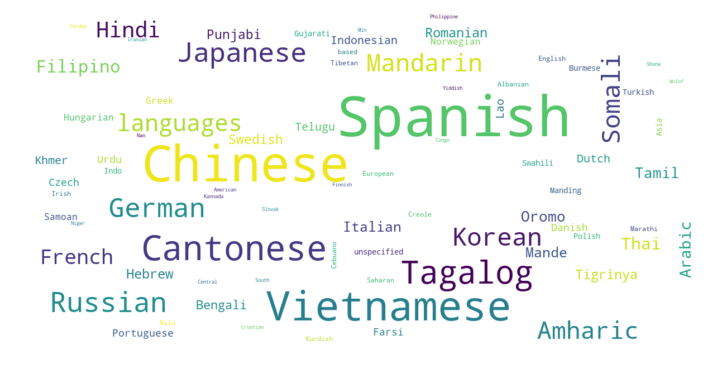

In [7]:
def wordCloud(Text):

    #sudo pip install wordcloud
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import numpy as np
    from PIL import Image
    from os import path
    import matplotlib.pyplot as plt
    import random

    # shape masked wordcloud
    #mask = np.array(Image.open("./Data/Tweets/seahawks.png"))
    #mask = np.array(Image.open("./Data/Tweets/map.jpg"))
    #image_colors = ImageColorGenerator(mask)

    # text wordcloud
    #wordcloud = WordCloud(max_font_size=100, width = 1200, height = 600, mode = 'RGBA', background_color = 'white').generate(' '.join(Text))
    wordcloud = WordCloud(collocations=False, max_font_size=100, width = 1200, height = 600, mode = 'RGBA', background_color = 'white').generate(' '.join(Text))
    
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("./Data/PUMS_Languages.png")

Languages = df_person['language'].tolist()
Languages = [x for x in Languages if str(x) != 'nan']
Languages = [x for x in Languages if str(x) != 'Nan']

wordCloud(Languages)

